### Import packages

In [1]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

### Load the dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root="./dataset", transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [3]:
image, label = dataset[0]
print(f"Label: {label}, Image shape: {image.shape}")

Label: 0, Image shape: torch.Size([3, 128, 128])


In [4]:
print(dataset.classes)

['kawung', 'mega_mendung', 'parang', 'truntum']


### Define the CNN model

In [5]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = self.pool(nn.ReLU()(self.conv4(x)))
        x = self.pool(nn.ReLU()(self.conv5(x)))

        x = x.view(-1, 512 * 4 * 4)

        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### Train, validate, and test the model

In [6]:
num_classes = len(dataset.classes)
model = CNNModel(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

model.train()

num_epoch = 100
for epoch in range(num_epoch):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/100, Loss: 1.3285
Epoch 2/100, Loss: 1.2050
Epoch 3/100, Loss: 1.0618
Epoch 4/100, Loss: 1.0127
Epoch 5/100, Loss: 0.9792
Epoch 6/100, Loss: 0.9434
Epoch 7/100, Loss: 0.9696
Epoch 8/100, Loss: 0.9244
Epoch 9/100, Loss: 0.8606
Epoch 10/100, Loss: 0.8156
Epoch 11/100, Loss: 0.7566
Epoch 12/100, Loss: 0.7618
Epoch 13/100, Loss: 0.6993
Epoch 14/100, Loss: 0.6565
Epoch 15/100, Loss: 0.7004
Epoch 16/100, Loss: 0.6276
Epoch 17/100, Loss: 0.6439
Epoch 18/100, Loss: 0.5929
Epoch 19/100, Loss: 0.5832
Epoch 20/100, Loss: 0.5425
Epoch 21/100, Loss: 0.5515
Epoch 22/100, Loss: 0.5542
Epoch 23/100, Loss: 0.5538
Epoch 24/100, Loss: 0.5303
Epoch 25/100, Loss: 0.5193
Epoch 26/100, Loss: 0.4891
Epoch 27/100, Loss: 0.4798
Epoch 28/100, Loss: 0.4694
Epoch 29/100, Loss: 0.4744
Epoch 30/100, Loss: 0.4283
Epoch 31/100, Loss: 0.4224
Epoch 32/100, Loss: 0.3946
Epoch 33/100, Loss: 0.3590
Epoch 34/100, Loss: 0.3565
Epoch 35/100, Loss: 0.3826
Epoch 36/100, Loss: 0.3226
Epoch 37/100, Loss: 0.3113
Epoch 38/1

In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation accuracy: {100 * correct / total:.2f}")

Validation accuracy: 77.78


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


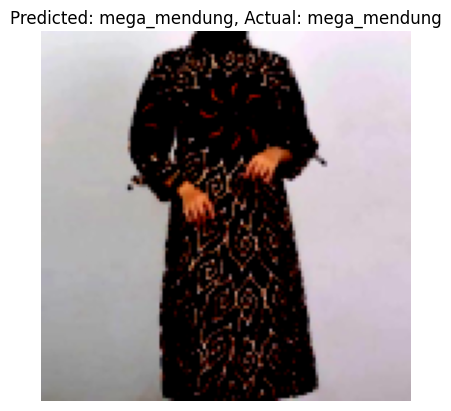

In [8]:
data_iter = iter(test_loader)
images, labels = next(data_iter)
random_id = random.randint(0, len(images) - 1)

image = images[random_id].unsqueeze(0).to(device)
label = labels[random_id].item()

model.eval()

with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

class_name = dataset.classes[predicted.item()]

plt.imshow(image.squeeze().cpu().permute(1, 2, 0))
plt.title(f"Predicted: {class_name}, Actual: {dataset.classes[label]}")
plt.axis("off")
plt.show()

In [9]:
torch.save(model.state_dict(), 'batik_classification_model.pth')